In [ ]:
!pip install pot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.4/835.4 kB 7.1 MB/s eta 0:00:00


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import ot
import pandas as pd
from sklearn.cluster import KMeans


def generar_muestra(a, sigma, cantidad_puntos):
    ''' Función para generar muestras en una reta con ruido
        param: a: Pendiente
               sigma: Varianza del ruido
               cantidad_puntos: Cantidad de puntos a simular

        output: Lista de x e y representando las coordenadas de los puntos sorteados
    '''
    x = np.random.rand(cantidad_puntos) * 20 - 10
    ruido = np.random.normal(loc=0, scale=sigma, size=cantidad_puntos)
    y = a*x + ruido

    return x, y

def rotacion(x, y, theta):
    ''' Función para rotar puntos en el plano un angulo theta
        param: x, y: coordeandas de los puntos (usualmente una lista para x y otra para y)
               theta: ángulo de rotación en radianes

        output:Lista de x2 e y2 representando las coordenadas de los puntos rotados
'''
    x2 = np.cos(theta) * x - np.sin(theta) * y
    y2 = np.sin(theta) * x + np.cos(theta) * y

    return x2, y2


def regresion_lineal(x, y):
    '''Función para calcular la regresión lineal
       param: x,y: coordeandas de los puntos (usualmente una lista para x y otra para y)

       output: Estimaciones de a y b, la pendiente y el intercept de la regresión
    '''
    n = len(x)
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_x2 = np.sum(x**2)
    sum_xy = np.sum(x*y)

    a_hat = (n * sum_xy - sum_x * sum_y) / (n * sum_x2 - sum_x ** 2)
    b_hat = (sum_y - a_hat * sum_x) / n

    return a_hat, b_hat

def regresion_rotada(a, b, theta):
    '''Función para 'rotar' los parámetros de una regresión
        param: a, b: Parámetros de la regresión original
              theta: ángulo de rotación en radianes

        output: Parámetros de la regresión rotada
    '''
    a_r = (a * np.cos(theta) + np.sin(theta)) / (np.cos(theta) - a * np.sin(theta))
    b_r = b * (a_r * np.sin(theta) + np.cos(theta))

    return a_r, b_r

def error_cuadratico_medio(y_real, y_pred):
    '''Función para calcular el ECM
       param: y_real: Lista de valores reales de y
              y_pred: Lista de valores predichos de y

        output: ECM
    '''
    return np.mean((y_real - y_pred) ** 2)



---
Comencemos viendo que si conocemos el ángulo de rotación, entonces podemos ajustar la regresión en $X_s$ (donde hay muchos datos) y obtener una mejor regresión en $X_t$ comparado con calcular la regresión directamente en $X_t$.
---

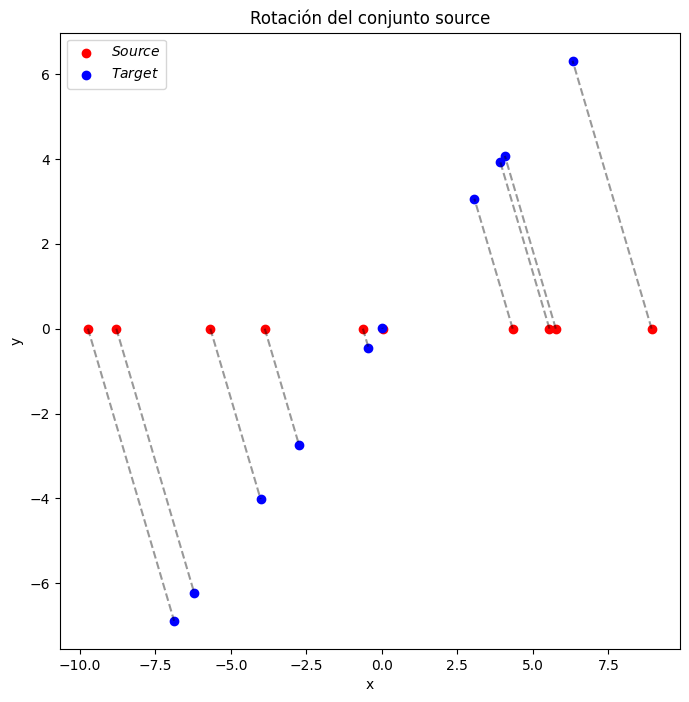

In [2]:
a1, sigma1, ns = 0, 0, 10
a2, sigma2, nt = 1, 0, 10
theta = np.pi/4

x1, y1 = generar_muestra(a1, sigma1, ns)
x_r, y_r = rotacion(x1, y1, np.pi/4)

Xs = np.vstack((x1, y1)).T
Xr = np.vstack((x_r, y_r)).T

# Densidades uniformes
mu = np.ones(nt) / nt
nu = np.ones(nt) / nt

# Calcular la matriz de costo
C = ot.dist(Xr, Xs, metric='euclidean')

# Resolución del prolema de Monge
P_gamma = ot.emd(mu, nu, C)

plt.figure(figsize=(8, 8))
plt.scatter(x1, y1, color="red", label=r'$Source$')
plt.scatter(x_r, y_r, color="blue", label=r'$Target$')

# Añadir las conexiones del transporte óptimo
for i in range(ns):
    for j in range(nt):
        if P_gamma[i, j] > 0:  # Solo dibujar si existe una conexión
            plt.plot([x1[j], x_r[i]], [y1[j], y_r[i]], 'k--', alpha=0.4)

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Rotación del conjunto source')
plt.show()


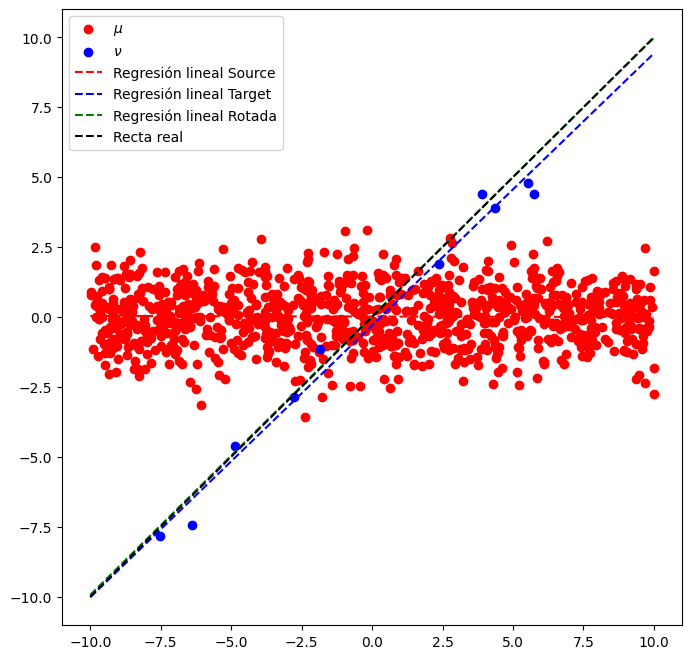

In [3]:
a1, sigma1, ns = 0, 1, 1000
a2, sigma2, nt = 1, 1, 10
theta = np.pi/4

x1, y1 = generar_muestra(a1, sigma1, ns)
x2, y2 = generar_muestra(a2, sigma2, nt)

x_r, y_r = rotacion(x1, y1, np.pi/4)

a1, b1 = regresion_lineal(x1, y1)
a2, b2 = regresion_lineal(x2, y2)
a_r, b_r = regresion_rotada(a1, b1, theta)


x = np.linspace(-10, 10, 100)
x_r, y_r = rotacion(x1, y1, np.pi/4)
plt.figure(figsize=(8, 8))
plt.scatter(x1, y1, color="red", label=r'$\mu$')
plt.scatter(x2, y2, color="blue", label=r'$\nu$')
plt.plot(x, a1*x + b1, "r--", label="Regresión lineal Source")
plt.plot(x, a2*x + b2, "b--", label="Regresión lineal Target")
plt.plot(x, a_r*x + b_r, "g--", label="Regresión lineal Rotada")
plt.plot(x, x, "k--", label="Recta real")
plt.legend()


In [4]:
mse = error_cuadratico_medio(x, a2*x + b2)
mse_r = error_cuadratico_medio(x, a_r*x + b_r)

print("MSE regresión calculado en X_t:", mse)
print("MSE regresión rotada:", mse_r)


MSE regresión calculado en X_t: 0.11556886076748904
MSE regresión rotada: 0.0010992488136833491


---
Dejamos fijo $n_t$ y variamos $n_s$ en $10, 10^2, 10^3, 10^4, 10^5, 10^6$. Para cada combinación de $n_t$ y $n_s$ realizamos $1000$ realizaciones de la simulación anterior.
---

In [5]:
# Parámetros
theta_conocido = np.pi / 4

a1, sigma1, ns = 0, 1, _
a2, sigma2, nt = 1, 1, 10

# Exponentes
exp =[1, 2, 3, 4, 5, 6]

MSE = {i: [] for i in exp}
MSE_r = {i: [] for i in exp}

for exponente in exp:
    ns = 10**exponente
    for _ in range(1000):
        x1, y1 = generar_muestra(0, 1, ns)
        x2, y2 = generar_muestra(1, 1, 10)

        # Create vector x for predictions in the range of -10 to 10
        x = np.linspace(-10, 10, 100)

        # Perform linear regression
        a1, b1 = regresion_lineal(x1, y1)
        a2, b2 = regresion_lineal(x2, y2)
        a_r, b_r = regresion_rotada(a1, b1, theta_conocido)

        # Calculate MSE
        y_real = x  # For y = x
        y_pred = a2 * x + b2
        y_pred_r = a_r * x + b_r

        mse = error_cuadratico_medio(y_real, y_pred)
        mse_r = error_cuadratico_medio(y_real, y_pred_r)

        MSE[exponente].append(mse)
        MSE_r[exponente].append(mse_r)

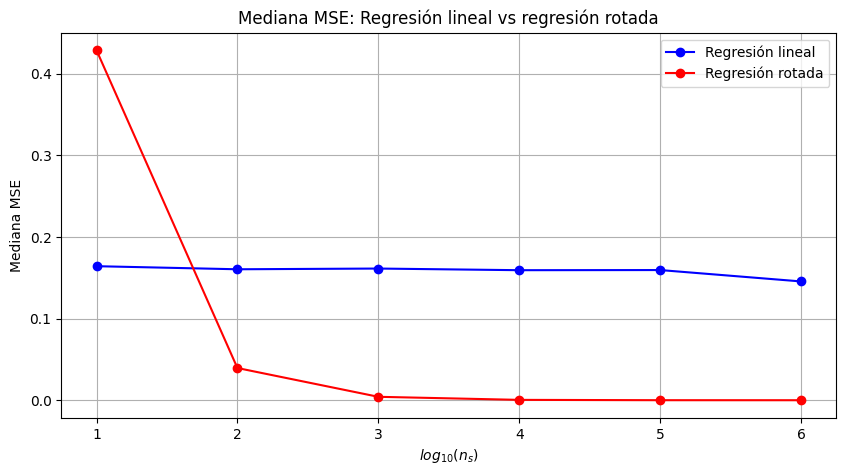

In [10]:
MSE_promedio = []
MSE_r_promedio = []

for k in MSE.keys():
    MSE_promedio.append(np.median(list(MSE[k])))

for k in MSE_r.keys():
    MSE_r_promedio.append(np.median(list(MSE_r[k])))




plt.figure(figsize=(10, 5))
plt.plot(list(MSE.keys()), MSE_promedio, marker='o', color="blue", label="Regresión lineal")
plt.plot(list(MSE.keys()), MSE_r_promedio, marker='o', color="red", label="Regresión rotada")


plt.xlabel(r'$log_{10}(n_s)$')
plt.ylabel('Mediana MSE')
plt.title('Mediana MSE: Regresión lineal vs regresión rotada')

plt.grid(True)
plt.legend()
plt.show()

In [9]:
data = {
    'log10(n_s)': list(MSE.keys()),
    'Mediana MSE (Regresión lineal)': MSE_promedio,
    'Mediana MSE (Regresión rotada)': MSE_r_promedio
}

df = pd.DataFrame(data)
print(df)


   log10(n_s)  Mediana MSE (Regresión lineal)  Mediana MSE (Regresión rotada)
0           1                        0.164187                        0.428760
1           2                        0.160415                        0.039448
2           3                        0.161311                        0.004191
3           4                        0.159287                        0.000435
4           5                        0.159465                        0.000038
5           6                        0.145519                        0.000004


Para tener mayores garantiaz, procedemos a graficar boxplot para cada $n_s$.

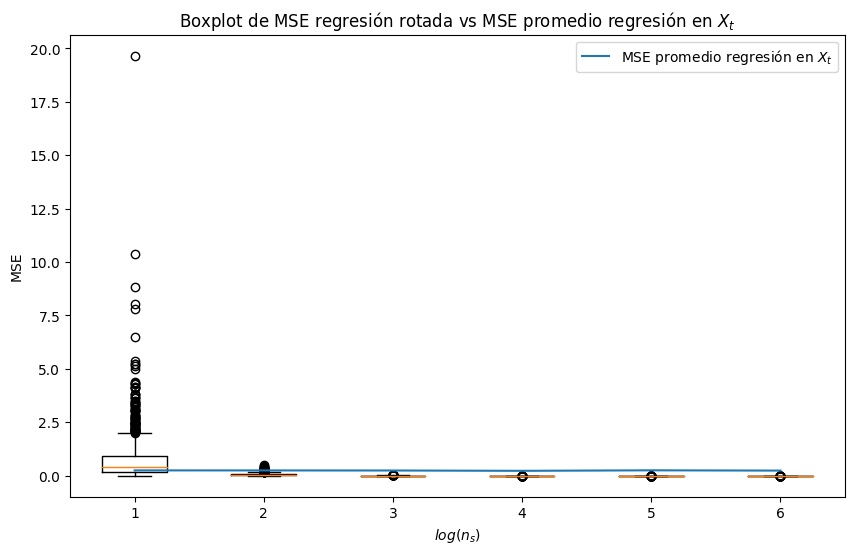

In [11]:
mean_data = {key: np.mean(values) for key, values in MSE.items()}

keys = list(MSE_r.keys())
values = [MSE_r[key] for key in keys]


plt.figure(figsize=(10, 6))
plt.boxplot(values, positions=keys)
plt.plot(list(mean_data.keys()), list(mean_data.values()), label=r"MSE promedio regresión en $X_t$")
plt.xlabel(r'$log(n_s)$')
plt.ylabel('MSE')
plt.title(r'Boxplot de MSE regresión rotada vs MSE promedio regresión en $X_t$')
plt.xticks(keys)
plt.legend()
plt.show()


---
A continuación estudiaremos como resulta lo anterior si utilizamos el transporte óptimo para estimar el ángulo de rotación
---
---

# Prueba con SVD

In [12]:
def estimacion_del_angulo_SVD(x1, y1, x2, y2, nt):
    """Función para estimar el ángulo de rotación utilizando transporte óptimo y SVD."""
    # Combinamos las coordenadas en un solo array para cada conjunto de muestras
    Xs = np.vstack((x1, y1)).T
    Xt = np.vstack((x2, y2)).T

    # K-means en Xs para obtener nt centroides
    kmeans = KMeans(n_clusters=nt, random_state=0, n_init=1).fit(Xs)
    centroides = kmeans.cluster_centers_

    # Densidades uniformes
    mu_centroides = np.ones(nt) / nt
    nu = np.ones(nt) / nt

    # Calcular la matriz de costo utilizando la distancia euclidiana
    C = ot.dist(centroides, Xt, metric='euclidean')

    # Resolución del problema de Monge
    P_gamma = ot.emd(mu_centroides, nu, C)

    # Mapear los centroides de Xs a los puntos en Xt usando la matriz de transporte
    indices_mapeados = np.argmax(P_gamma, axis=1)
    centroides_transportados = Xt[indices_mapeados]

    # Usar SVD para estimar la rotación
    H = np.dot(centroides.T, centroides_transportados)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # Asegurarse de que la matriz de rotación no refleje los puntos
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = np.dot(Vt.T, U.T)

    # Estimar el ángulo de rotación
    theta = np.arctan2(R[1, 0], R[0, 0])

    return theta


In [13]:
# Parámetros
theta_conocido = np.pi / 4

a1, sigma1, ns = 0, .5, _
a2, sigma2, nt = 1, .5, 10

# Exponentes
exp =[2, 3, 4, 5, 6]

MSE_estimado = {i: [] for i in exp}
MSE_r_estimado = {i: [] for i in exp}

A_r = {i: [] for i in exp}
B_r = {i: [] for i in exp}

A_2 = {i: [] for i in exp}
B_2 = {i: [] for i in exp}



for exponente in exp:
  ns = 10**exponente
  print(ns)
  for rep in range(1000):
    if rep % 100 == 0:
      print(rep)

    x1, y1 = generar_muestra(0, 1, ns)
    x2, y2 = generar_muestra(1, 1, nt)

    theta_estimado = estimacion_del_angulo_SVD(x1, y1, x2, y2, nt)

    x = np.linspace(-10, 10, 100)

    # Regresiones
    a_1, b_1 = regresion_lineal(x1, y1)
    a_2, b_2 = regresion_lineal(x2, y2)
    a_r, b_r = regresion_rotada(a1, b1, theta_estimado)

    A_2[exponente].append(a_2)
    B_2[exponente].append(b_2)

    A_r[exponente].append(a_r)
    B_r[exponente].append(b_r)

    # Cálculo MSE
    y_real = x
    y_pred = a_2 * x + b_2
    y_pred_r = a_r * x + b_r

    mse = error_cuadratico_medio(y_real, y_pred)
    mse_r = error_cuadratico_medio(y_real, y_pred_r)

    MSE_estimado[exponente].append(mse)
    MSE_r_estimado[exponente].append(mse_r)

100
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
10000
0
100
200
300
400
500
600
700
800
900
100000
0
100
200
300
400
500
600
700
800
900
1000000
0
100
200
300
400
500
600
700
800
900


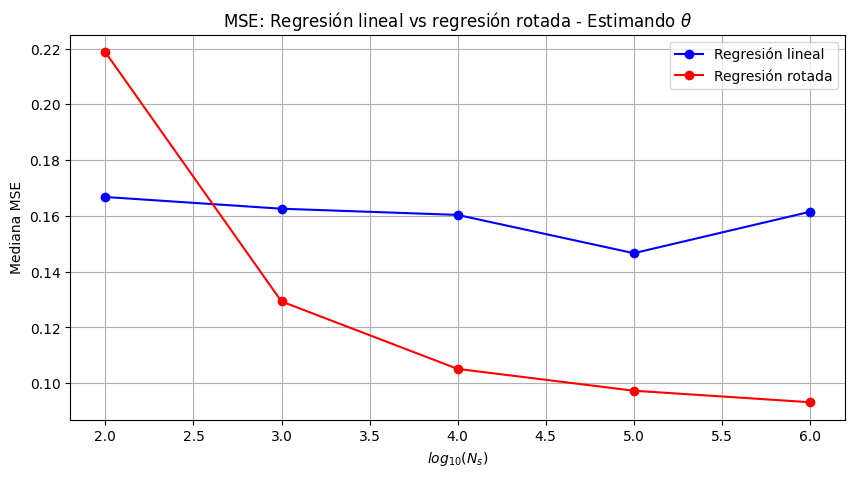

In [17]:
MSE_estimado_promedio = []
MSE_r_estimado_promedio = []

for k in MSE_estimado.keys():
    MSE_estimado_promedio.append(np.median(list(MSE_estimado[k])))

for k in MSE_r_estimado.keys():
    MSE_r_estimado_promedio.append(np.median(list(MSE_r_estimado[k])))



plt.figure(figsize=(10, 5))
plt.plot(list(MSE_estimado.keys()), MSE_estimado_promedio, marker='o', color="blue", label="Regresión lineal")
plt.plot(list(MSE_estimado.keys()), MSE_r_estimado_promedio, marker='o', color="red", label="Regresión rotada")


plt.xlabel(r'$log_{10}(N_s)$')
plt.ylabel('Mediana MSE')
plt.title(r'MSE: Regresión lineal vs regresión rotada - Estimando $\theta$')

plt.grid(True)
plt.legend()
plt.show()

In [21]:
data_rotado = {
    'log10(n_s)': list(MSE_estimado.keys()),
    'Mediana MSE (Regresión lineal)': MSE_estimado_promedio,
    'Mediana MSE (Regresión rotada)': MSE_r_estimado_promedio
}

df_r = pd.DataFrame(data_rotado)
print(df_r)

   log10(n_s)  Mediana MSE (Regresión lineal)  Mediana MSE (Regresión rotada)
0           2                        0.166780                        0.218713
1           3                        0.162574                        0.129299
2           4                        0.160353                        0.105116
3           5                        0.146619                        0.097287
4           6                        0.161478                        0.093161


---
Boxplot
---
---

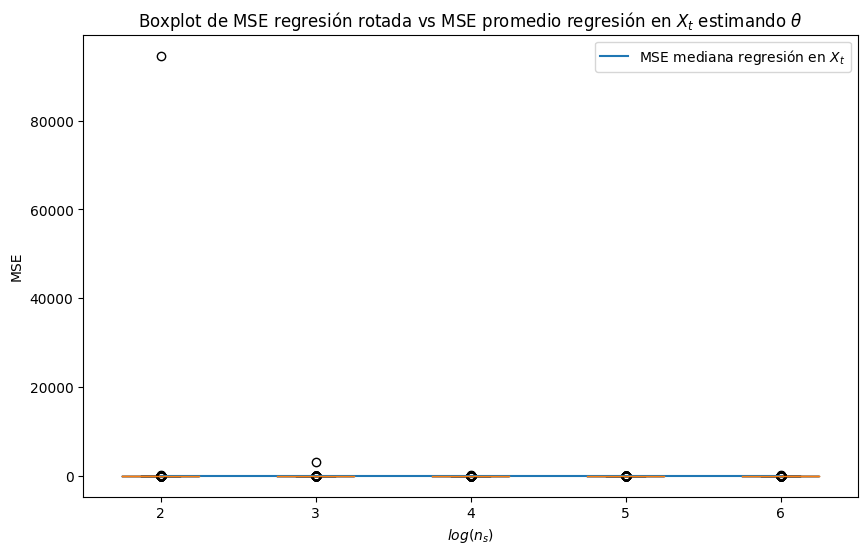

In [23]:
# Filtrar claves mayores a 1
keys = [key for key in MSE_r_estimado.keys() if key > 1]
values = [MSE_r_estimado[key] for key in keys]
median_data = {key: np.median(MSE_estimado[key]) for key in keys}

# Generar el gráfico
plt.figure(figsize=(10, 6))
plt.boxplot(values, positions=keys)
plt.plot(list(median_data.keys()), list(median_data.values()), label=r"MSE mediana regresión en $X_t$")
plt.xlabel(r'$log(n_s)$')
plt.ylabel('MSE')
plt.title(r'Boxplot de MSE regresión rotada vs MSE promedio regresión en $X_t$ estimando $\theta$')
plt.xticks(keys)
plt.legend()
plt.show()

In [24]:
A_r_promedio = []
B_r_promedio = []

A_2_promedio = []
B_2_promedio = []


for k in A_r.keys():
    A_r_promedio.append(np.mean(list(A_r[k])))
    B_r_promedio.append(np.mean(list(B_r[k])))
    A_2_promedio.append(np.mean(list(A_2[k])))
    B_2_promedio.append(np.mean(list(B_2[k])))
    


## Para cada k= 2, 3, 4, calculamos el a_r y b_r promedio de las 1000 iteraciones. Vamos a generar las rectas y = a_r x + b_r y compararlas con la obtenida mediante los datos de target

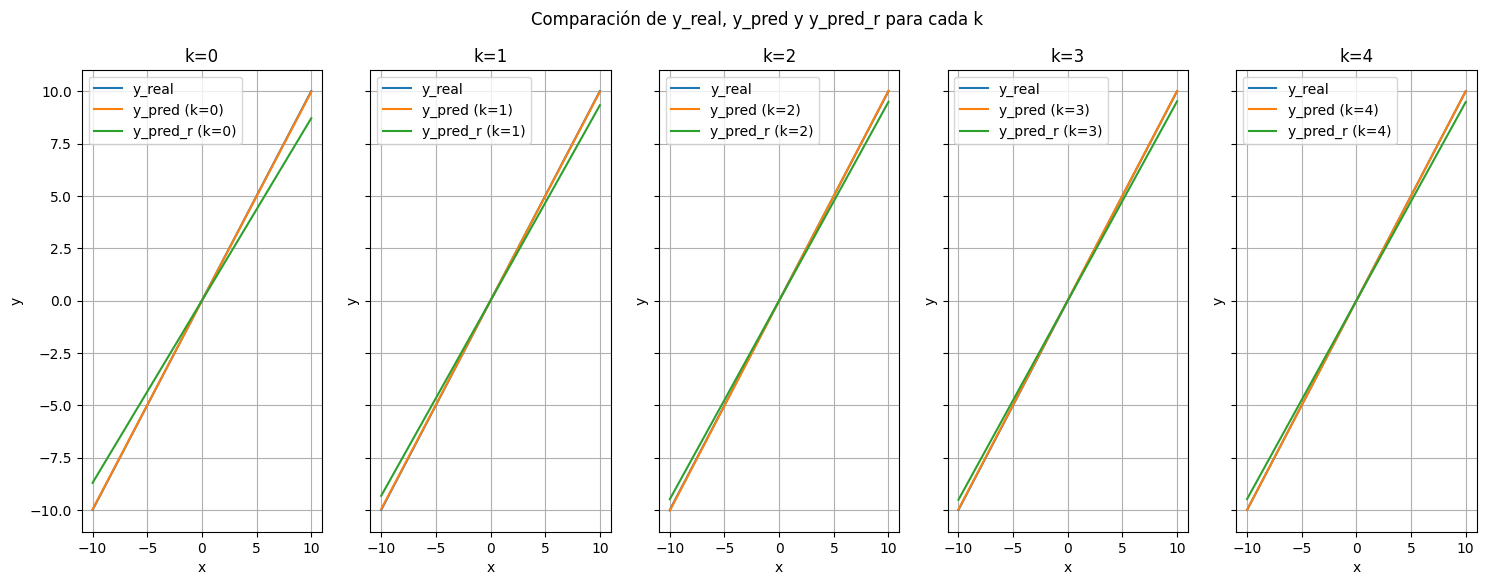

In [25]:
x = np.linspace(-10, 10, 100)

MSE_p = []
MSE_r_p = []

fig, axes = plt.subplots(1, 5, figsize=(18, 6), sharey=True)

for k in range(5):
    y_real = x
    y_pred = A_2_promedio[k]*x + B_2_promedio[k]
    y_pred_r = A_r_promedio[k]*x + B_r_promedio[k]
    MSE_p.append(error_cuadratico_medio(y_real, y_pred))
    MSE_r_p.append(error_cuadratico_medio(y_real, y_pred_r))

    axes[k].plot(x, x, label='y_real')
    axes[k].plot(x, y_pred, label=f'y_pred (k={k})')
    axes[k].plot(x, y_pred_r, label=f'y_pred_r (k={k})')
    axes[k].set_xlabel('x')
    axes[k].set_ylabel('y')
    axes[k].set_title(f'k={k}')
    axes[k].legend()
    axes[k].grid(True)

fig.suptitle('Comparación de y_real, y_pred y y_pred_r para cada k')
plt.show()